A written summary of this notebook can be found here:
TBD


# Downloading the necessary packages and data

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, RandomForestClassifier

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
main2=pd.read_pickle('Data/data_from_imdb_extra.pkl')

In [6]:
main2.columns

Index(['imdb_id', 'titles', 'year', 'original_air_date', 'countries',
       'language', 'genres', 'certificates', 'rating', 'votes', 'color_info',
       'runtimes', 'box_office', 'producers', 'directors',
       'production_company', 'distributors', 'metascore', 'is_nominee',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave'],
      dtype='object')

In [9]:
month_df=pd.read_pickle('Data/df_of_months')
prodcomp_df=pd.read_pickle('Data/df_previous_nom_production_comp.pkl')

In [10]:
month_df.head(2)

,imdb_id,day,month,year,country,month_num
0,0388130,13,Jan,2001,(Japan),1
1,0273772,17,Jan,2001,(France),1


In [11]:
prodcomp_df.head(2)

,imdb_id,prev nom pcomp,prev nom pcomp encoded
0,0388130,Not Previously Nominated,0
1,0273772,Not Previously Nominated,0


In [12]:
main2['month']=month_df['month_num']
main2['prev_pc'] = prodcomp_df['prev nom pcomp encoded']

In [17]:
main2['runtimes']

0       [100]
1        [70]
2        [99]
3        [46]
4        [81]
        ...  
3896     [70]
3897     [78]
3898     [60]
3899     [90]
3900     [89]
Name: runtimes, Length: 3901, dtype: object

In [20]:
runtime_ints=[]
for i in range(len(main2)):
    runtime_ints.append(main2.iloc[i]['runtimes'][0])

In [21]:
main2['runtime_ints'] = runtime_ints

In [22]:
main2.to_pickle('Data/data_from_imdb_extra_2.pkl')

# Splitting the test and training data

In [23]:
main_df=pd.read_pickle('Data/data_from_imdb_extra_2.pkl')

In [24]:
#create a dataframe that drops given years
def drop_test(df,L):
    '''input a dataframe of movies (df) and a list of years as int (L)
    outputs a dataframe that does not include the movies in years in L'''
    indices =[]
    for i in range(len(df)):
        if df.iloc[i]['year'] in L:
            indices.append(i)
    new_df=df.drop(indices)
    return(new_df)

In [25]:
train_set=drop_test(main2, [2018,2019,2020,2021])

In [26]:
def timeseries_split(df, k):
    '''takes in a movie dataframe (df),  k (int)
    and outputs a tuple that behaves like kfold.split when kfold =kfold = TimeSeriesSplit(n_splits = k,
                           test_size = 1)
    that is, the output is a tuple of 2-tuples, where
    the first element of each tuple is the indices of the train set and
    the second element is the indices of the test set
    unlike TimeSeriesSplit it can only handle one dataframe at a time'''
    if len(df['year'].value_counts()) <k:
        raise ValueError("Not enough data for given k")
        
    df=df.copy()
    
    answer=[]
    i=0
    while i <k:
        last_year=df['year'].max()
        
        #get array of indices of last year in list
        index_set=np.array(df[df['year']==last_year].index)
        
        #delete rows from dataframe
        df=drop_test(df,[last_year])
        #print(len(df))
        
        #add to train_sets
        index_set2=np.array(df.index)
        
        new_set=(index_set2, index_set)
        answer=[new_set] + answer
        
        i=i+1
    
    return tuple(answer)

# Models based on more features

In [27]:
train_set.columns

Index(['imdb_id', 'titles', 'year', 'original_air_date', 'countries',
       'language', 'genres', 'certificates', 'rating', 'votes', 'color_info',
       'runtimes', 'box_office', 'producers', 'directors',
       'production_company', 'distributors', 'metascore', 'is_nominee',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave', 'month', 'prev_pc',
       'runtime_ints'],
      dtype='object')

In [28]:
viable_columns = [
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave', 'month', 'prev_pc',
       'runtime_ints']

### Random Forest

In [29]:
def est_forest(j):
    '''goes through j n-estimaters values on decision trees on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        k=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make random forest with maxdepth=10 and n_estimators=80
            tree=RandomForestClassifier(n_estimators=80, max_depth=10)
            tree.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=tree.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,k]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,k]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            k=k+1

    return(precs, recs)

In [30]:
metrics_forest=est_forest(1)

In [31]:
metrics_forest

(array([[1.        , 0.6       , 0.66666667, 0.8       , 0.33333333]]),
 array([[0.66666667, 0.6       , 0.66666667, 0.8       , 0.2       ]]))

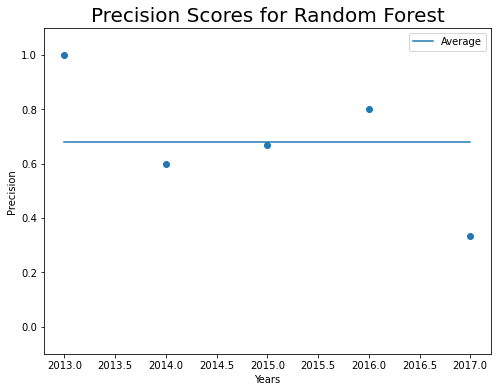

In [45]:
plt.figure(figsize=(8,6))

plt.scatter(range(2013,2018), metrics_forest[0])

plt.plot(range(2013,2018), 5*[np.mean(metrics_forest[0])], label='Average')

plt.title('Precision Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

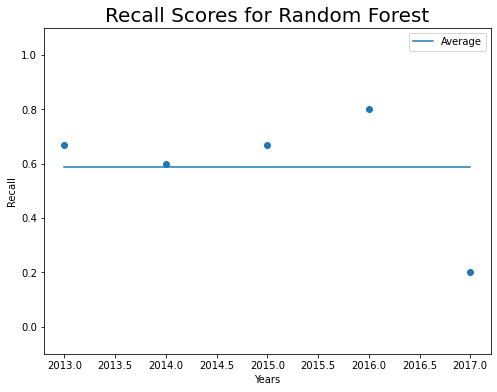

In [54]:
plt.figure(figsize=(8,6))

plt.scatter(range(2013,2018), metrics_forest[1])

plt.plot(range(2013,2018), 5*[np.mean(metrics_forest[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [42]:
print('Recall:')
print(np.mean(metrics_forest[1], axis=1))
print('Precision:')
print(np.mean(metrics_forest[0], axis=1))

Recall:
[0.58666667]
Precision:
[0.68]


#### <font color='MediumOrchid'>For Random Forests, these metrics are both lower than before we incorporated the new features. </font>

### k Nearest Neighbors Classifier

In [47]:
def est_knn(j):
    '''goes through k in range(1,j+1) on kNN models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1, p=1)
            kNN.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=kNN.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [48]:
metrics_knn=est_knn(1)

In [49]:
metrics_knn

(array([[0.33333333, 0.8       , 0.66666667, 0.44444444, 0.28571429]]),
 array([[0.16666667, 0.8       , 0.66666667, 0.8       , 0.4       ]]))

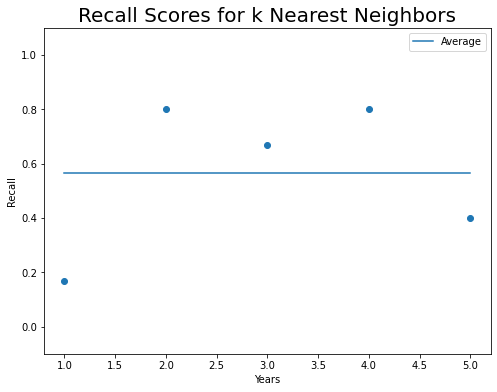

In [55]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_knn[1])

plt.plot(range(1,6), 5*[np.mean(metrics_knn[1])], label='Average')

plt.title('Recall Scores for k Nearest Neighbors', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

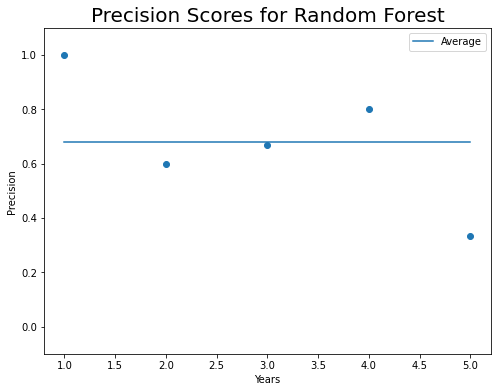

In [56]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_forest[0])

plt.plot(range(1,6), 5*[np.mean(metrics_forest[0])], label='Average')

plt.title('Precision Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [53]:
print('Recall:')
print(np.mean(metrics_knn[1], axis=1)[0])
print('Precision:')
print(np.mean(metrics_knn[0], axis=1)[0])

Recall:
0.5666666666666667
Precision:
0.506031746031746


#### <font color='MediumOrchid'> For kNN, the precision increased but the recall decreased when adding features. Precision is decreasing over time.
</font>

### Logistic Regression

In [61]:
def est_log_reg(j):
    '''goes through C in range(j) on logistic regression models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            logreg = LogisticRegression(C=2**(-1*5), max_iter=1000)
            logreg.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=logreg.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [62]:
metrics_logreg=est_log_reg(1)

In [63]:
metrics_logreg

(array([[1.        , 0.75      , 0.75      , 0.55555556, 1.        ]]),
 array([[0.5, 0.6, 1. , 1. , 0.4]]))

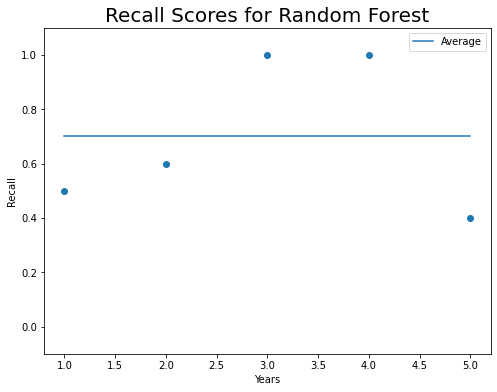

In [65]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_logreg[1])

plt.plot(range(1,6), 5*[np.mean(metrics_logreg[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

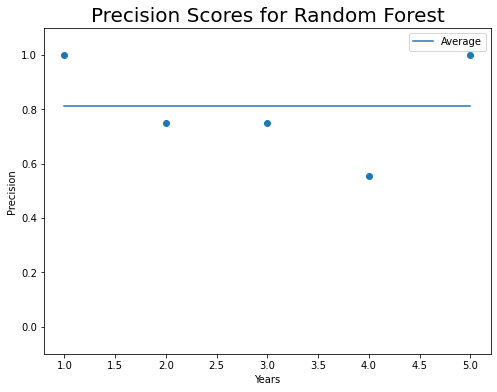

In [66]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_logreg[0])

plt.plot(range(1,6), 5*[np.mean(metrics_logreg[0])], label='Average')

plt.title('Precision Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [75]:
print('Recall:')
print(np.mean(metrics_logreg[1]))
print('Precision:')
print(np.mean(metrics_logreg[0]))

Recall:
0.7
Precision:
0.8111111111111111


#### <font color='MediumOrchid'> For Logistic Regression, recall went down but precision went up by a lot when adding features </font>

### Support Vector Machines

In [70]:
def est_poly_svc(j):
    '''goes through C in range(j) on SVC models on training set.
    with polynomial degree n
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            svc = SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=10000)
            svc.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [71]:
metrics_poly=est_poly_svc(1)

In [72]:
metrics_poly

(array([[1.        , 0.5       , 0.66666667, 0.66666667, 1.        ]]),
 array([[0.33333333, 0.2       , 0.66666667, 0.8       , 0.2       ]]))

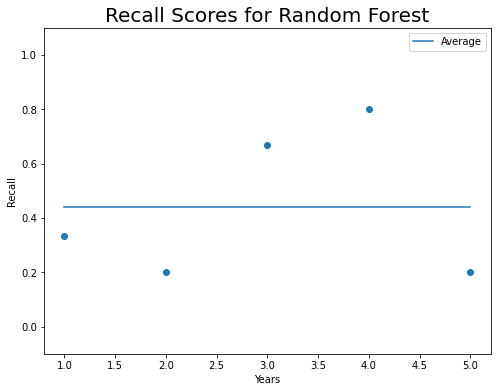

In [73]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_poly[1])

plt.plot(range(1,6), 5*[np.mean(metrics_poly[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

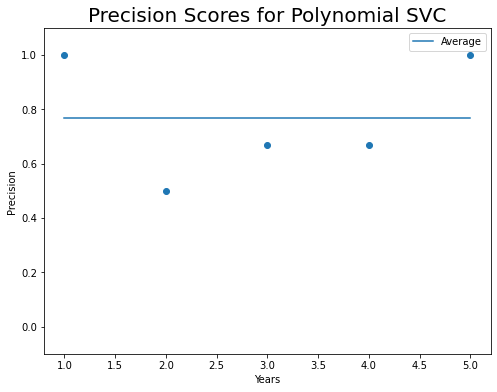

In [74]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_poly[0])

plt.plot(range(1,6), 5*[np.mean(metrics_poly[0])], label='Average')

plt.title('Precision Scores for Polynomial SVC', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [77]:
print('Recall:')
print(np.mean(metrics_poly[1], axis=1))
print('Precision:')
print(np.mean(metrics_poly[0], axis=1))

Recall:
[0.44]
Precision:
[0.76666667]


#### <font color=MediumOrchid> For SVC, both precision and recall went down when adding features. </font>

# A Voting Model based on the above

In [78]:
def voting(n):
    '''n = weights of the voting model
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((n,5))
    recs = np.zeros((n,5))
    for i in range(0,n):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make voting model 
            voting = VotingClassifier([
                ('forest',RandomForestClassifier(max_depth=10, n_estimators=80)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
                ('svc', SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=10000)),
                ('log_reg', LogisticRegression(C=2**(-1*5), max_iter=1000))
                                    ],
                weights=None)
            voting.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=voting.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [79]:
metrics_voting=voting(1)

In [80]:
metrics_voting

(array([[1.        , 0.75      , 0.66666667, 0.66666667, 1.        ]]),
 array([[0.33333333, 0.6       , 0.66666667, 0.8       , 0.4       ]]))

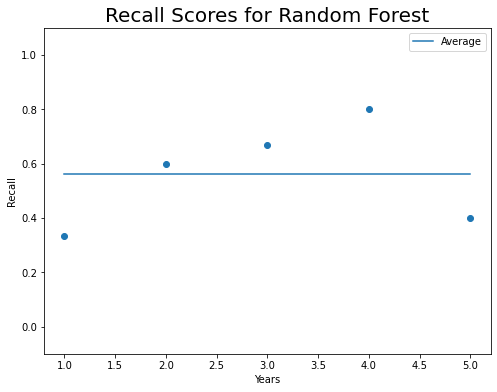

In [81]:
plt.figure(figsize=(8,6))

plt.scatter(range(1,6), metrics_voting[1])

plt.plot(range(1,6), 5*[np.mean(metrics_voting[1])], label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [82]:
print('Recall:')
print(np.mean(metrics_voting[1]))
print('Precision:')
print(np.mean(metrics_voting[0]))

Recall:
0.56
Precision:
0.8166666666666667


#### <font color=MediumOrchid> Precision went up but recall went down </font>

# Trends over validation sets

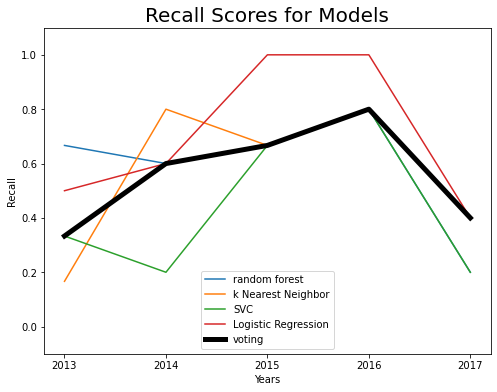

In [94]:
plt.figure(figsize=(8,6))



plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_forest[1]).reshape(-1,1), label='random forest')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_knn[1]).reshape(-1,1), label='k Nearest Neighbor')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_poly[1]).reshape(-1,1), label='SVC')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_logreg[1]).reshape(-1,1), label='Logistic Regression')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[1]).reshape(-1,1), linewidth=5, 
         label='voting',color='k')

plt.title('Recall Scores for Models', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

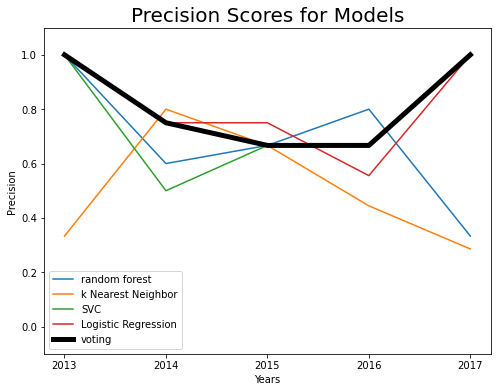

In [93]:
plt.figure(figsize=(8,6))


plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_forest[0]).reshape(-1,1), label='random forest')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_knn[0]).reshape(-1,1), label='k Nearest Neighbor')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_poly[0]).reshape(-1,1), label='SVC')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_logreg[0]).reshape(-1,1), label='Logistic Regression')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[0]).reshape(-1,1),linewidth=5, 
         label='voting', color='k')

plt.title('Precision Scores for Models', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

# Leaving off features

# A different train-test split

# Ensemble types